In [57]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from lifetimes import BetaGeoFitter, GammaGammaFitter
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
ecomm_df = pd.read_excel('NoA-Connect-JrDataScience-Case.xlsx', parse_dates=['order_date'])

## EDA
The section where I explore the data and decide on key features.

In [ ]:
# View the first 5 rows of the database
ecomm_df.head()

,order_id,purchase_amount,currency,order_date,customer_id
0,06c4bd28-eda3-42df-b819-aa19157a7d45,15.29,EUR,2025-01-22,835ec885-114a-4f7f-b2a4-d7b45dc74411
1,3daaf5f9-b2c2-457a-9abf-330e279fc5c0,37.19,EUR,2025-01-22,74093a26-a976-42f8-b5c1-fcef1faebe9c
2,33e1834f-db37-4a99-9be5-e45886b4dfd4,56.37,EUR,2025-01-22,a27631c8-3fbd-4ace-a46f-c65b2c5928d2
3,0b51225c-0ffe-4b4a-990b-f266f58e51aa,24.19,EUR,2025-01-22,2d5c1cad-07eb-439f-8ffa-9cd8ced6cea2
4,8d635007-5ab8-4680-988a-6ac5a93ea14b,24.79,USD,2025-01-22,48a9bdca-dbf9-41b3-be54-93cf62d257da


In [ ]:
# Finding the different currencies used when purchasing
ecomm_df['currency'].unique()

array(['EUR', 'USD', 'GBP'], dtype=object)

In [ ]:
# Calculating the total amount spent in each currency
print(ecomm_df.groupby(['currency'])[['purchase_amount']].sum())

          purchase_amount
currency                 
EUR            2629573.61
GBP              47751.42
USD             268018.47


## Barplot
Create a simple barplot to visualise how much of each currency the business has taken in.

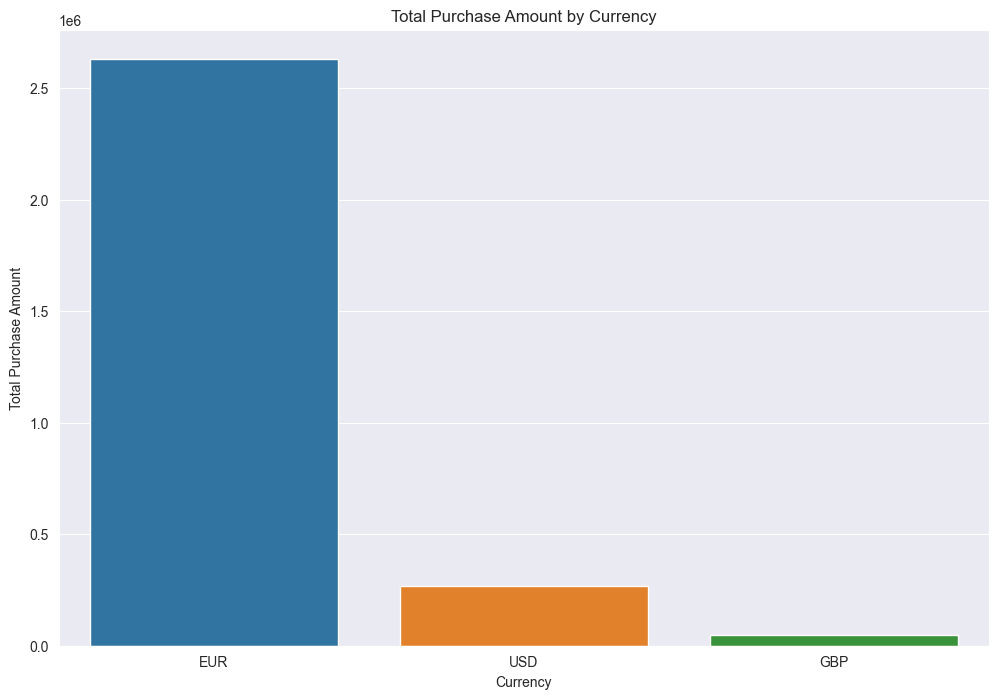

In [ ]:
# Sort by total purchase amount per currency 
ecomm_df_curr = ecomm_df.groupby("currency", as_index=False)["purchase_amount"].sum().sort_values(by="purchase_amount", ascending=False)

# Set plot style
sns.set_style('darkgrid')

# Create figure and axis
plt.figure(figsize=(12, 8))

# Create barplot
sns.barplot(data=ecomm_df_curr, x="currency", y="purchase_amount", hue="currency")

# Improve labeling
plt.xlabel("Currency")
plt.ylabel("Total Purchase Amount")
plt.title("Total Purchase Amount by Currency")

# Show plot
plt.show()


## Overview
What are the key statistical features of database; including the mean, standard deviation, and percentiles.

In [132]:
ecomm_df.describe()

,purchase_amount,order_date
count,51948.000000,51948
mean,56.697919,2024-05-30 02:21:20.665280768
min,0.000000,2023-01-01 00:00:00
25%,17.140000,2024-02-19 00:00:00
50%,25.190000,2024-06-21 00:00:00
75%,41.980000,2024-10-06 00:00:00
max,13976.400000,2025-01-22 00:00:00
std,207.860065,NaN


What stands out above is how the mean order amount is 57, but the highest individual order amount is 13,976. This is a huge gap. Clearly, the max amount is an outlier.

In [ ]:
# Check to see the datatypes and if there are any null values
ecomm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51948 entries, 0 to 51947
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   order_id         51948 non-null  object        
 1   purchase_amount  51948 non-null  float64       
 2   currency         51948 non-null  object        
 3   order_date       51948 non-null  datetime64[ns]
 4   customer_id      51948 non-null  object        
 5   order_month      51948 non-null  period[M]     
dtypes: datetime64[ns](1), float64(1), object(3), period[M](1)
memory usage: 2.4+ MB


In [131]:
ecomm_df.shape

(51948, 6)

## Income Over Time
How much did the business make over the 2 year period we have data for.

In [133]:
# Group orders by month for simpler graph
ecomm_df['order_month'] = ecomm_df['order_date'].dt.to_period('M')
monthly_df = ecomm_df.groupby(['order_month', 'currency'], as_index=False)['purchase_amount'].sum()
monthly_df['order_month'] = monthly_df['order_month'].astype(str)

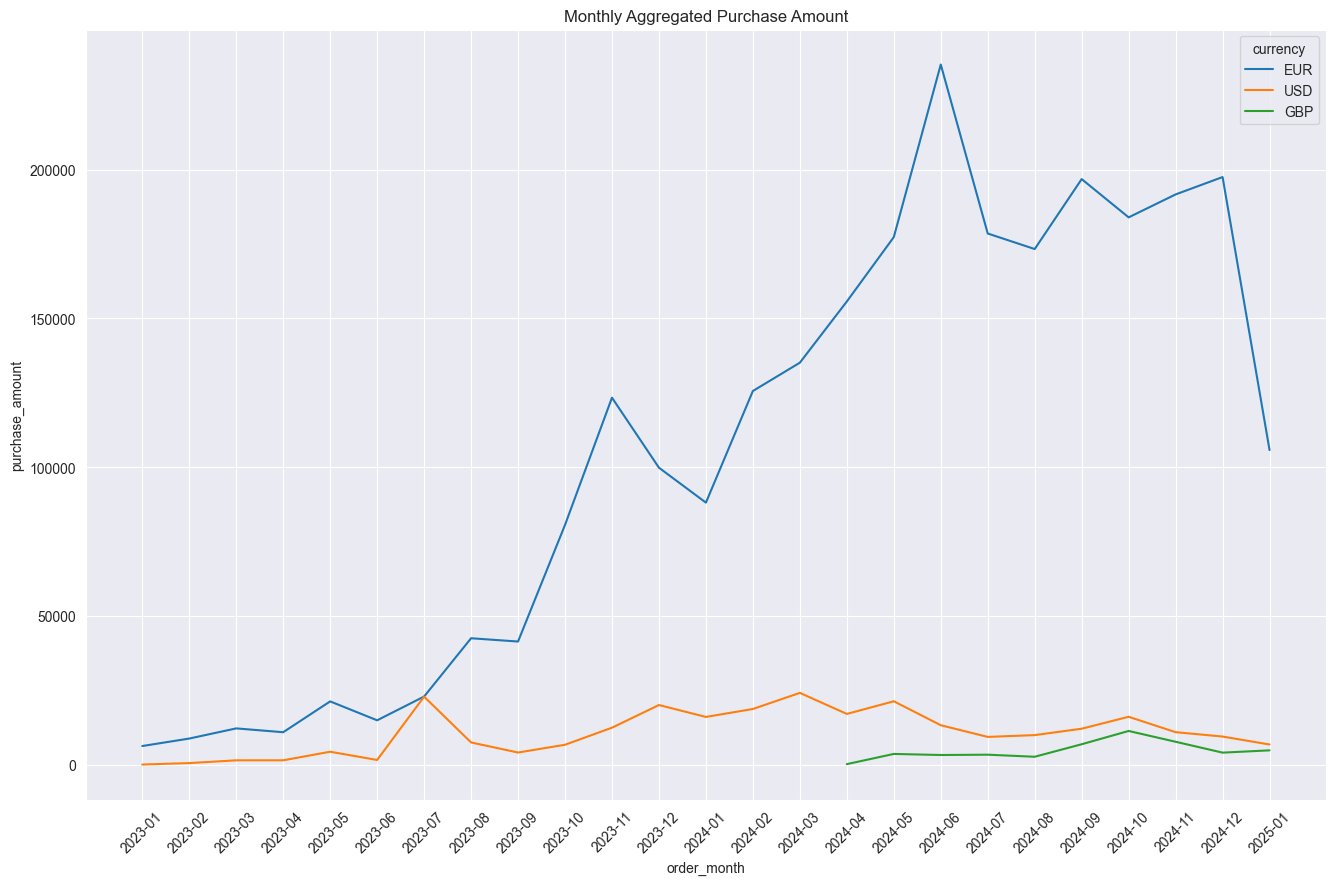

In [134]:
plt.figure(figsize=(16,10))
sns.lineplot(x="order_month", y="purchase_amount",
             hue="currency",
             data=monthly_df)

plt.xticks(rotation=45)
plt.title("Monthly Aggregated Purchase Amount")
plt.show()

In [ ]:
login_counts = ecomm_df['customer_id'].value_counts()
single_logins = (login_counts == 1).sum()
print("The number of single purchase logins are:", single_logins)

The number of single logins are: 4505


In [136]:
ecomm_df.nunique()

order_id           51948
purchase_amount     7067
currency               3
order_date           750
customer_id         7373
order_month           25
dtype: int64

There was a high number (4505 of 7373) of customers that used the service only once. This is a key component to the company increasing it's business going forward.

In [ ]:
# Getting a better idea of the number who have spent big
big_spenders = ecomm_df[ecomm_df['purchase_amount'] > 8000]['customer_id'].unique()
print(big_spenders)

['a01b746c-88c9-45e2-ad7a-6ef25d10c7d8'
 '9e4062c6-2573-4d82-b0c6-f9f29978dc9e'
 '919cdf1c-443c-495c-b2de-f96cdd121a71']


## Calculating Customer Lifetime Value (CLV)
**Customer lifetime value (CLV)** is a business metric that measures how much a business can plan to earn from the average customer over the course of the relationship. This should tell us if marketing campaigns are working or if an intervention is needed to improve overall sales.

In [176]:
# Aggregate to customer level
clv_data = ecomm_df.groupby('customer_id').agg(
    frequency=('order_id', 'count'),  # Number of repeat purchases
    recency=('order_date', lambda x: (x.max() - x.min()).days),  # Days between first & last purchase
    T=('order_date', lambda x: (ecomm_df['order_date'].max() - x.min()).days),  # Customer's age (days)
    monetary_value=('purchase_amount', 'mean')  # Average order value
).reset_index()

'Frequency' is a measure of how many times people have used the site. 'Recency' is a measure of the time between puchases. Obviously, if frequency is 1 then recency must be 0.

In [160]:
clv_data.head()

,customer_id,frequency,recency,T,monetary_value
0,00235c62-e617-4eb0-a050-470c9f30e87f,1,0,441,26.990000
1,00341635-2bff-4605-b3d0-ea405649659d,3,301,308,90.016667
2,003fb56f-aa7f-4dd9-83bd-2209bb1076d4,1,0,224,129.520000
3,004c365f-ed0a-4287-af51-77c29fc32803,2,48,176,30.275000
4,004db925-5b13-4cf3-baac-df11e6e9b04b,2,16,219,59.600000


In [ ]:
# Checking for any null values that might throw off our measurements.
print(clv_data.isnull().sum())

customer_id       0
frequency         0
recency           0
T                 0
monetary_value    0
dtype: int64


## Frequency Boxplot 
A simple visual just to get a visual idea of how frequently used the site is.

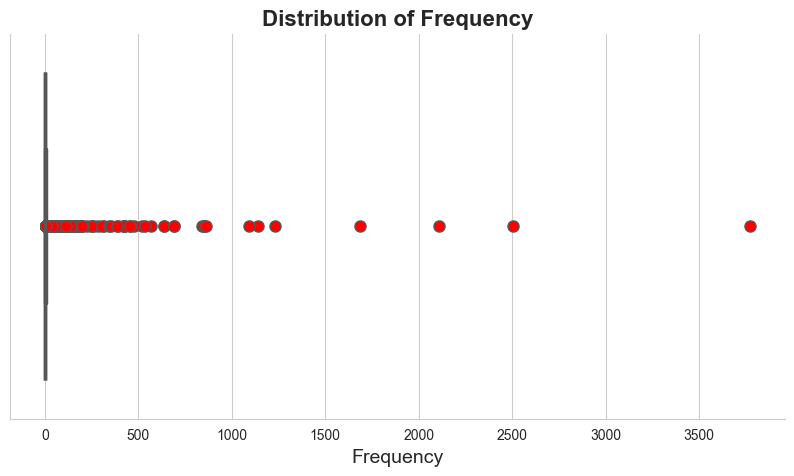

In [143]:
# Set style
sns.set_style("whitegrid")  
plt.figure(figsize=(10, 5))  # Increase figure size

# Create the boxplot
ax = sns.boxplot(
    data=clv_data, 
    x='frequency', 
    color='royalblue', 
    linewidth=2.5,  
    flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 8}  # Style outliers
)

# Add title and labels
ax.set_title("Distribution of Frequency", fontsize=16, fontweight='bold')
ax.set_xlabel("Frequency", fontsize=14)

# Remove top and right spines for a cleaner look
sns.despine()

plt.show()


## Fitting the data to a CLV model
This model predicts *how often* a customer will buy again. First off, we need to prepare the data so it can be fit using BetaGeoFitter. It is sensitive to outliers and to a high quantity of low frequncy numbers. All frequencies of 1 are removed, as well as any outliers above the 95th percentile. 'T' is a measure of the total time the customer has been observed. This value must be greater than or equal to Recency (time between purchases) so the data must be checked and all offending values removed. 

In [182]:
# Filter out first-time customers (BG/NBD requires at least one repeat purchase)
clv_data = clv_data[clv_data['frequency'] > 1]

In [ ]:
clv_data['T'] = clv_data['T'].clip(upper=clv_data['T'].quantile(0.95))  # Cap at the 95th percentile
# Check that no recency values are greater than T
clv_data = clv_data[clv_data['recency'] <= clv_data['T']]


Log1p() is used as it's helpful when data is skewed (as it is in this case). It helps to compress extreme values, as well as improving the model's stability.

In [184]:
clv_data['monetary_value'] = np.log1p(clv_data['monetary_value'])


In [188]:
# Fit BG/NBD model (predicts future transactions)
bgf = BetaGeoFitter()
bgf.fit(clv_data['frequency'], clv_data['recency'], clv_data['T'])

<lifetimes.BetaGeoFitter: fitted with 2834 subjects, a: 1.09, alpha: 3.53, b: 4.72, r: 0.56>

The results show that:
* __Customer tend to churn (b > a)__ - the churn risk variation is greater than the churn behaviour. Customer retention is an issue.

* __Moderate purchase frequecy__ - we saw that there was a high number of customers that only shopped once. There is a small number that purchase often and spend a lot. This has levelled the overall purchase frequency figure.

* __High alpha rate__ - this implies that the customers who do love the site are faithful and stable in the frequency of purchasing and the amounts spent. This is something to build upon


In [190]:
print(clv_data[clv_data['monetary_value'] <= 0])


                               customer_id  frequency  recency    T  \
4046  8931dde7-9950-493b-8865-25e09d14eeb4          4       41  244   

      monetary_value  
4046             0.0  


In [ ]:
# Ensures that all monetary values are positive
clv_data = clv_data[clv_data['monetary_value'] > 0]


## Gamma Gamma Model Prediction
This model takes the previously fitted clv data and predicts how much customers will spend on each transaction.\
__Final CLV = (Predicted Transactions from BG/NBD) × (Predicted Value from Gamma-Gamma)__

In [192]:
# Fit Gamma-Gamma model (predicts monetary value per purchase)
ggf = GammaGammaFitter()
ggf.fit(clv_data['frequency'], clv_data['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2833 subjects, p: 57.24, q: 159.56, v: 4.48>

These results tell us that:
* __Most customers spend similar amounts per purchase (p = 57.24)__ - we saw that with the large number of single users, and the low mean purchase amount. We know that there are a small number of outliers who spend vastly more than the average.

* __High spenders will continue to spend (q = 159.56)__ - the value for q is very high which means it is likely that previous high purchasers will continue this trend. This suggests a strong central product that inspires high loyalty in a core group. Emphasis should be placed on extending this group outwards.

* __Average transaction value is low (v = 4.48)__ - At the moment the business relies on small transactions despite the high amount and likelihood of churn.


## Predict CLV using Gamma Gamma
This code predicts the __Customer Lifetime Value (CLV)__ for each customer over the next 12 months using the __BG/NBD (Beta-Geometric Negative Binomial Distribution)__ and __Gamma-Gamma models__.

In [193]:
# Predict CLV
clv_data['CLV'] = ggf.customer_lifetime_value(
    bgf,  
    clv_data['frequency'], 
    clv_data['recency'], 
    clv_data['T'], 
    clv_data['monetary_value'], 
    time=12,  
    freq="D",  
    discount_rate=0.01  
)

print(clv_data[['customer_id', 'CLV']].head())

                            customer_id       CLV
1  00341635-2bff-4605-b3d0-ea405649659d  4.224614
3  004c365f-ed0a-4287-af51-77c29fc32803  0.936819
4  004db925-5b13-4cf3-baac-df11e6e9b04b  0.048109
5  0052d0bb-94f7-47b4-ad1f-ae1f03bfe005  6.435082
6  0054705a-66d4-4d5f-8d6c-0abc2655f800  0.005359


The header data shows the predicted total spending of each customer over the next year.

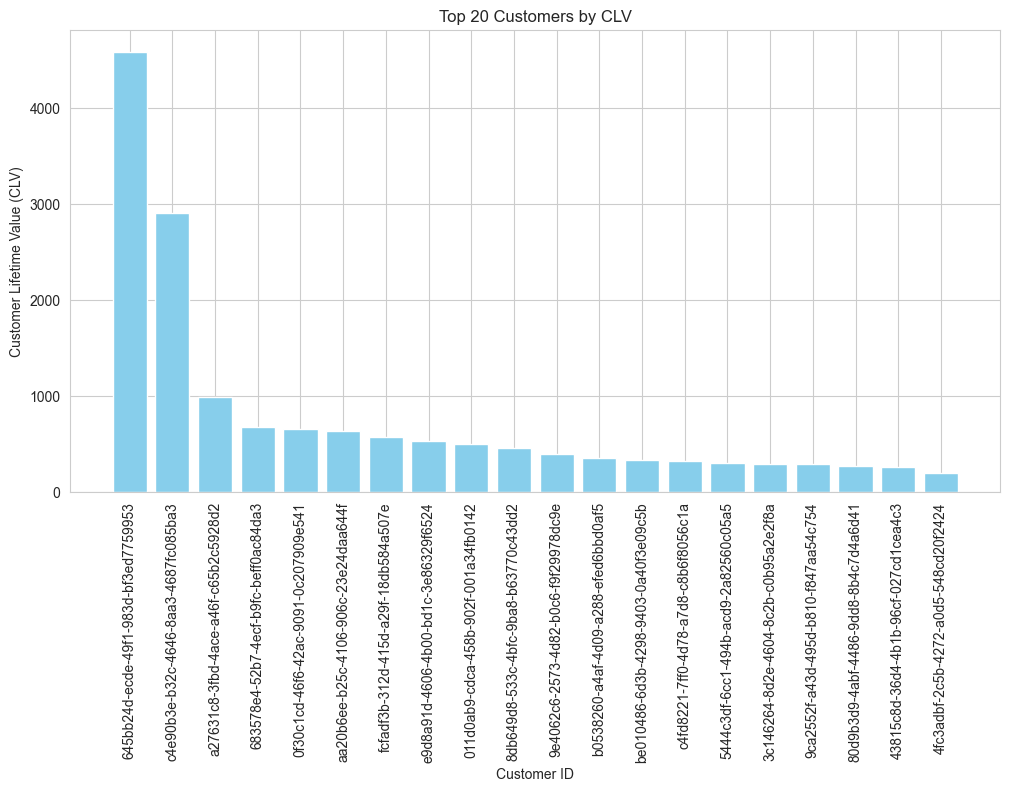

In [194]:
# Sort by CLV and take top 20 customers
top_customers = clv_data.nlargest(20, 'CLV')

plt.figure(figsize=(12, 6))
plt.bar(top_customers['customer_id'], top_customers['CLV'], color='skyblue')
plt.xticks(rotation=90)  # Rotate customer IDs for readability
plt.xlabel("Customer ID")
plt.ylabel("Customer Lifetime Value (CLV)")
plt.title("Top 20 Customers by CLV")
plt.show()

In accordance with earlier theories, the business relies largely on a small number of high paying numbers. Even though the graph only shows the first 20 customers we can see how skewed the graph already is. The film memorabilia site's profits rely on a few high-value customers and many low-value ones.

Text(0.5, 1.0, 'Relationship Between Purchase Frequency and CLV')

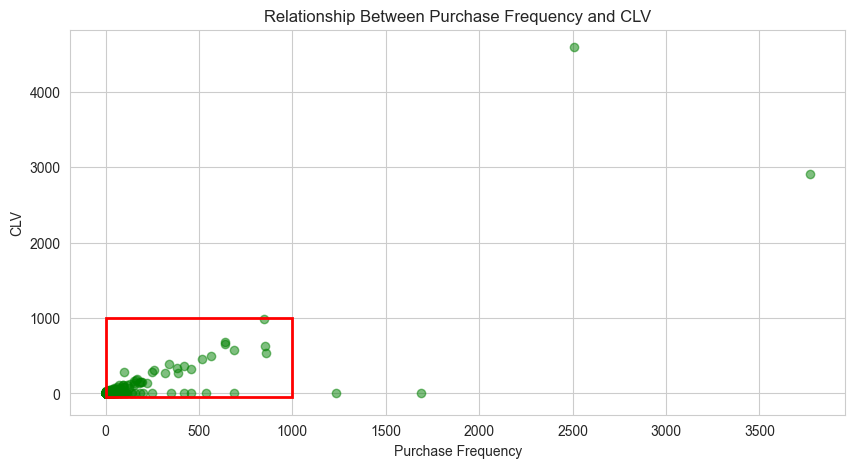

In [209]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(10, 5))
plt.scatter(clv_data['frequency'], clv_data['CLV'], alpha=0.5, color='green')
plt.gca().add_patch(Rectangle((0, -50), 1000, 1050, linewidth=2, edgecolor='red', facecolor='none'))
plt.xlabel("Purchase Frequency")
plt.ylabel("CLV")
plt.title("Relationship Between Purchase Frequency and CLV")

It's clear how two outliers have greatly affected company profits. Their CLV is huge (especially in comparison), which is positive in that we predict continued loyalty, but make future profitability unsecure and unpredictable.

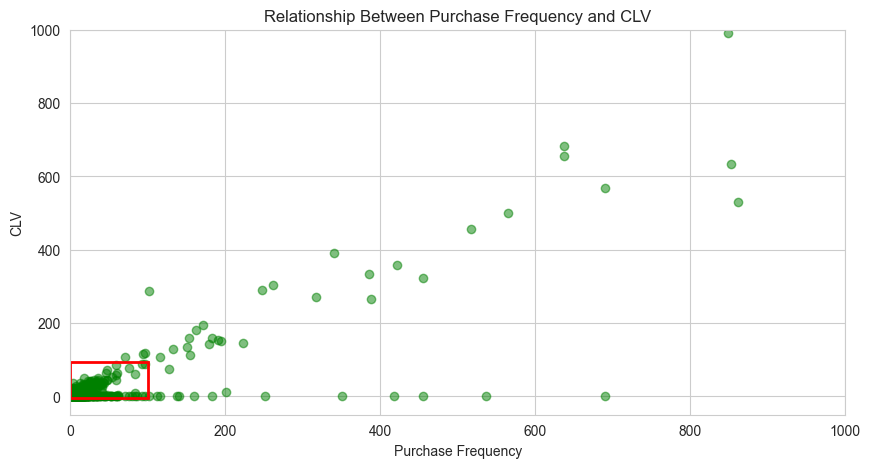

In [213]:
plt.figure(figsize=(10, 5))
plt.scatter(clv_data['frequency'], clv_data['CLV'], alpha=0.5, color='green')
plt.gca().add_patch(Rectangle((0, -5), 100, 100, linewidth=2, edgecolor='red', facecolor='none'))
plt.xlabel("Purchase Frequency")
plt.ylabel("CLV")
plt.title("Relationship Between Purchase Frequency and CLV")
# Set limits as outliers made it unclear
plt.xlim(0, 1000) 
plt.ylim(-50, 1000)  
plt.show()

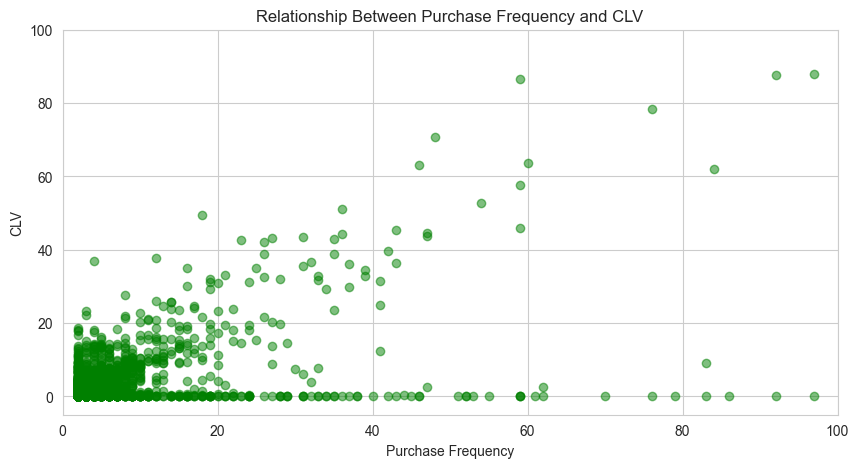

In [212]:
plt.figure(figsize=(10, 5))
plt.scatter(clv_data['frequency'], clv_data['CLV'], alpha=0.5, color='green')
plt.xlabel("Purchase Frequency")
plt.ylabel("CLV")
plt.title("Relationship Between Purchase Frequency and CLV")
# Set limits as outliers made it unclear
plt.xlim(0, 100) 
plt.ylim(-5, 100)  
plt.show()

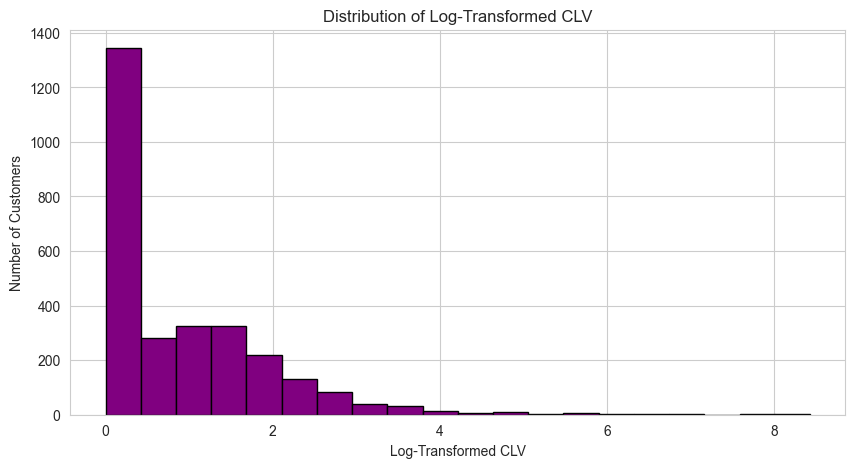

In [197]:
# Apply log transformation (add 1 to avoid log(0) issues)
clv_data['log_CLV'] = np.log1p(clv_data['CLV'])

# Plot histogram of log-transformed CLV
plt.figure(figsize=(10, 5))
plt.hist(clv_data['log_CLV'], bins=20, color='purple', edgecolor='black')
plt.xlabel("Log-Transformed CLV")
plt.ylabel("Number of Customers")
plt.title("Distribution of Log-Transformed CLV")
plt.show()


The histogram has been log transformed to compress the scale of the larger values.